In [1]:
import time, os
from scipy.ndimage import maximum_filter1d, find_objects
import torch
import numpy as np
import tifffile
from tqdm import trange
from numba import njit, float32, int32, vectorize
import cv2
import fastremap
import gunpowder as gp
import math
import zarr
import imageio
import matplotlib.pyplot as plt

import logging
from cellpose import dynamics
# dynamics_logger = logging.getLogger(__name__)

#from cellpose import utils, metrics, transforms

import torch
from torch import optim, nn
# from torch import resnet_torch
TORCH_ENABLED = True 
torch_GPU = torch.device('cuda')
torch_CPU = torch.device('cpu')

In [2]:
# This loads the zarr file
load_path = '/mnt/efs/shared_data/hack/data/20230811/20230811_raw.zarr'
f = zarr.open(load_path, 'r')
f['fov0/raw'].shape

(64, 640, 640)

In [7]:
f['fov0/gt'].shape

(64, 640, 640)

In [14]:
# get a crop

mask = f['fov0/gt'][20, 250:450,250:450]
mask.shape

(200, 200)

In [21]:
# add another dimension to the shape of mask
maskexpand = np.expand_dims(mask, axis=0)

TypeError: Invalid shape (200,) for image data

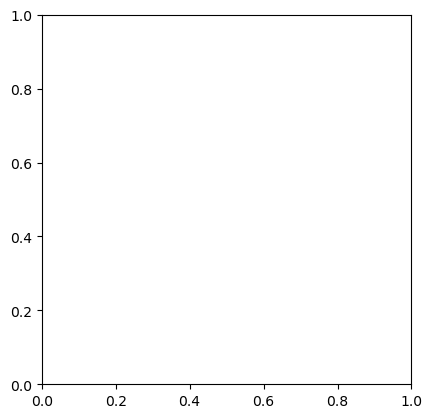

In [25]:
plt.imshow(maskexpand[0,0,])

In [23]:
maskoutput = dynamics.masks_to_flows(maskexpand)

## USE THIS to take in the masks, compute the flows from them, and then save the flows

/home/michaels/conda/envs/zarr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/michaels/conda/envs/zarr/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
maskoutput.shape

(3, 1, 200, 200)

In [35]:
np.squeeze(maskoutput, axis=1).shape

(3, 200, 200)

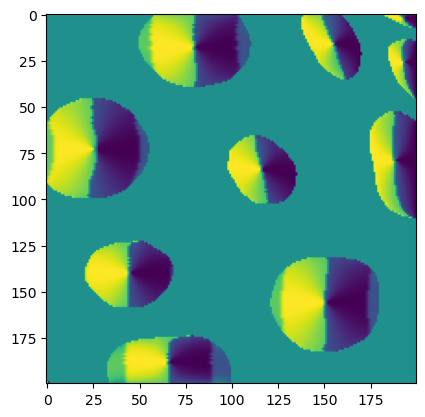

In [29]:
plt.imshow(maskoutput[2,0])

In [30]:
class maskstocellpose_flows(gp.BatchFilter):

  def __init__(self, in_array, out_array):
    self.in_array = in_array
    self.out_array = out_array

  def setup(self):

    # tell downstream nodes about the new array
    self.provides(
      self.out_array,
      self.spec[self.in_array].copy())

  def prepare(self, request):

    # to deliver inverted raw data, we need raw data in the same ROI
    deps = gp.BatchRequest()
    deps[self.in_array] = request[self.out_array].copy()

    return deps

  def process(self, batch, request):

    # take the masks and compute the flows
    flows = dynamics.masks_to_flows(batch[self.in_array].data)


    # create the array spec for the new array
    spec = batch[self.in_array].spec.copy()
    spec.roi = request[self.out_array].roi.copy()

    # create a new batch to hold the new array
    batch = gp.Batch()

    # create a new array
    flowarray = gp.Array(flows, spec)

    # store it in the batch
    batch[self.out_array] = flowarray

    # return the new batch
    return batch

In [31]:
# declare a new array key for inverted raw
flows_array = gp.ArrayKey('FLOW')

In [ ]:
source = tuple(gp.ZarrSource(
    load_path,
    {
      raw: f'fov{i}/raw',
      gt: f'fov{i}/gt'
    },
    {
      raw: gp.ArraySpec(interpolatable=True,
        voxel_size=(1,1)),
      gt: gp.ArraySpec(interpolatable=False,
        voxel_size=(1,1)),
    }) + normalize + pad_raw + pad_gt + random_location for i in [1])

    # This is the pipeline we are using
pipeline = source
pipeline += gp.RandomProvider()
pipeline += simple_augment
pipeline += elastic_augment
pipeline += intensity_augment
pipeline += noise_augment
pipeline += maskstocellpose_flows(masks)
  # +stack
  # reject
  # )


# formulate a request for "raw"
request = gp.BatchRequest()
request[raw] = gp.Roi((0,0), (256, 256))
request[gt] = gp.Roi((0,0), (256, 256))
request[flows_array] = gp.Roi((0, 0), (256, 256))


# build the pipeline...
with gp.build(pipeline):

    # ...and request a batch
    batch = pipeline.request_batch(request)

# show the content of the batch
print(f"batch returned: {batch}")

imshow(batch[raw].data, ground_truth=batch[flows_array].data, slice_index = 12)

In [32]:
# ## Got here - need to build in our pipeline there
# pipeline = (
#   source +
#   normalize +
#   random_location +
#   maskstocellpose_flows(masks))

# request = gp.BatchRequest()
# request[raw] = gp.Roi((0, 0), (128, 128))
# request[flows_array] = gp.Roi((0, 0), (128, 128))

# with gp.build(pipeline):
#   batch = pipeline.request_batch(request)

# imshow(batch[raw].data, batch[inverted_raw].data)

NameError: name 'source' is not defined

In [8]:
# Make an array key for the raw data and the ground truth
raw = gp.ArrayKey('RAW')
gt = gp.ArrayKey('GROUND_TRUTH')

#%%

random_location = gp.RandomLocation()
simple_augment = gp.SimpleAugment()
stack = gp.Stack(5)

elastic_augment = gp.ElasticAugment(
  control_point_spacing=(20, 20),
  jitter_sigma=(1.0, 1.0),
  rotation_interval=(0, math.pi/2))

normalize = gp.Normalize(raw)
intensity_augment = gp.IntensityAugment(
  raw,
  scale_min=0.8,
  scale_max=1.2,
  shift_min=-0.2,
  shift_max=0.2)
noise_augment = gp.NoiseAugment(raw)

pad_raw = gp.Pad(raw, None)
pad_gt = gp.Pad(gt, 0)



# Make this 'pipeline' thingy
source = tuple(gp.ZarrSource(
    store_path,
    {
      raw: f'fov{i}/raw',
      gt: f'fov{i}/gt'
    },
    {
      raw: gp.ArraySpec(interpolatable=True,
        voxel_size=(1,1)),
      gt: gp.ArraySpec(interpolatable=False,
        voxel_size=(1,1)),
    }) + normalize + pad_raw + pad_gt + random_location for i in [1])


# pipeline = source + random_location + simple_augment + elastic_augment + intensity_augment + noise_augment
pipeline = source
pipeline += gp.RandomProvider()
pipeline += simple_augment
pipeline += elastic_augment
pipeline += intensity_augment
pipeline += noise_augment
  # +stack
  # reject
  # )


# formulate a request for "raw"
request = gp.BatchRequest()
request[raw] = gp.Roi((0,0), (128, 128))
request[gt] = gp.Roi((0,0), (128, 128))

# build the pipeline...
with gp.build(pipeline):

    # ...and request a batch
    batch = pipeline.request_batch(request)

# show the content of the batch
print(f"batch returned: {batch}")

NameError: name 'store_path' is not defined